In [8]:
import sys
sys.path.append("OpticalFlowToolkit/")
import lib.flowlib as optical_flow_lib
import numpy as np
import matplotlib.pyplot as plt

In [155]:
import cv2

def open_flow(flow_path):
    return optical_flow_lib.read_flo_file(flow_path)

def open_image(image_path):
    img = cv2.imread(image_path)
    return img

def apply_flow(image, flow):
    h, w = flow.shape[:2]
    # pixel_map = -flow       # negative flow to go back from end to beginning image
    # pixel_map[:,:,0] += np.arange(w)               # x
    # pixel_map[:,:,1] += np.arange(h)[:,np.newaxis] # y
    map_x = flow[:,:,0] + np.arange(w)
    map_x = map_x.astype('float32')
    map_y = flow[:,:,1] + np.arange(h)[:,np.newaxis]
    map_y = map_y.astype('float32')
    new_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    return new_image

def calculate_loss(image1, image2):
    return cv2.norm(image1, image2, cv2.NORM_L2)

%matplotlib inline 
def show_image(image):
    image_show = cv2.cvtColor(image, cv2.cv.CV_BGR2RGB)
    plt.imshow(image_show)

In [190]:
def new_loss(image_prev, image_after, flow):
    h, w = flow.shape[:2]
    flow_x = flow[:,:,0]
    flow_y = flow[:,:,1]
    sum_abs_flow = abs(flow_x) + abs(flow_y)
    nonzeros = np.nonzero(sum_abs_flow) # indices where the flow is not nul in x or y direction
    nonzeros_after =  nonzeros[0] + flow_x[nonzeros].astype('int'), nonzeros[1] + flow_y[nonzeros].astype('int')
    
    ## keep only positive indexes
    # filter negative x values
    nx = (nonzeros_after[0] >= 0).nonzero()
    nonzeros_after = [nonzeros_after[0][nx], nonzeros_after[1][nx]]
    nonzeros = [nonzeros[0][nx], nonzeros[1][nx]]
    # filter negative y values
    ny = (nonzeros_after[1] >= 0).nonzero()
    nonzeros_after = [nonzeros_after[0][ny], nonzeros_after[1][ny]]
    nonzeros = [nonzeros[0][ny], nonzeros[1][ny]]
    
    ## Discard values that are too high
    # filter too high x values
    nx = (nonzeros_after[0] < image_prev.shape[0]).nonzero()
    nonzeros_after = [nonzeros_after[0][nx], nonzeros_after[1][nx]]
    nonzeros = [nonzeros[0][nx], nonzeros[1][nx]]
    ## filter too high y values
    ny = (nonzeros_after[1] < image_prev.shape[1]).nonzero()
    nonzeros_after = [nonzeros_after[0][ny], nonzeros_after[1][ny]]
    nonzeros = [nonzeros[0][ny], nonzeros[1][ny]]
    
    return cv2.norm(image_prev[nonzeros], image_after[nonzeros_after], cv2.NORM_L2), nonzeros, nonzeros_after

    ## TODO : what to do when the flow is nul ?


In [186]:
flow = open_flow("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-gt.flo")
it0 = open_image("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-img0.ppm")
it1 = open_image("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-img1.ppm")
it0_expected = apply_flow(it1, flow)

norm, nonzeros = new_loss(it0, it1, flow)
print calculate_loss(it0, it0_expected)
print norm
cv2.norm(it0[nonzeros], it1[nonzeros], cv2.NORM_L2)

Reading 384 x 512 flow file in .flo format
22228.3748169
33246.7173267


33432.78467313185

In [187]:
a = (np.array([2, -1, 3, -5, 6]), np.array([2, -1, -3, 3, 7]))


In [199]:
image_0 = np.array([
    [1, 5, 6],
    [3, 6, 4],
    [8, 5, 10]
])
image_1 = np.array([
    [0, 1, 5],
    [8, 3, 6],
    [4, 5, 10]
])

flow_test = np.array([
    [ [0, 1], [0,1], [0,1]],
    [ [0, 1], [0,1], [0,1]],   
    [ [-1, 0], [0,0], [0,0]]
])

In [200]:
new_loss(image_0, image_1, flow_test)

(0.0,
 [array([0, 0, 1, 1, 2]), array([0, 1, 0, 1, 0])],
 [array([0, 0, 1, 1, 1]), array([1, 2, 1, 2, 0])])

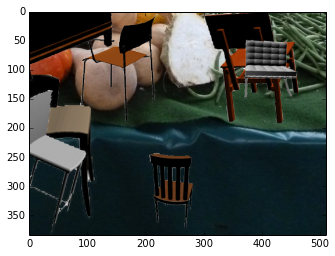

In [20]:
show_image(it1)

In [4]:
def apply_flow_path(second_image_path, incoming_flow_path, output_path):
    second_image = open_image(second_image_path)
    incoming_flow = open_flow(incoming_flow_path)
    expected_first_image = apply_flow(second_image, incoming_flow)
    cv2.imwrite(output_path, expected_first_image)

In [60]:
apply_flow_path("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-img0.ppm", 
               "/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-gt.flo", 
               "/home/gpu_user/corentin/images/expected-0000000-img1.ppm")

Reading 384 x 512 flow file in .flo format


In [58]:
image_end = open_image("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-img1.ppm")
flow = open_flow("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-gt.flo")
image_start_expected = apply_flow(image_end, flow)
image_start_actual = open_image("/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-img0.ppm")
optical_flow_lib.save_flow_image(flow, "/home/gpu_user/corentin/flownet2/data/FlyingChairs_examples/0000000-gt-flo.png")
loss1 = calculate_loss(image_start_expected, image_start_actual)
loss1

Reading 384 x 512 flow file in .flo format
max flow: 77.9450
flow range:
u = -75.656 .. 38.031
v = -28.719 .. 29.094


37205.50327572522

In [97]:
it1 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0312.jpg")
flow = open_flow("/home/gpu_user/corentin/images/lake_output/out-0.flo")
it0_exp = apply_flow(it1, flow)
it0 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0292.jpg")
cv2.imwrite("/home/gpu_user/corentin/images/lake_output/140106-0008-0292_expected.jpg", it0_exp)
optical_flow_lib.save_flow_image(flow, "/home/gpu_user/corentin/images/lake_output/out-0-flo.png")

Reading 480 x 704 flow file in .flo format


True

In [54]:
calculate_loss(image_end, image_start_actual)

27530.657002694286

# Flownet2-s

In [100]:
it0 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0292.jpg")
it1 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0312.jpg")
flow = open_flow("/home/gpu_user/corentin/Flownet2-s/0292.jpg.flo")
it0_exp = apply_flow(it1, flow)
cv2.imwrite("/home/gpu_user/corentin/Flownet2-s/140106-0008-0292_expected.jpg", it0_exp)
optical_flow_lib.save_flow_image(flow, "/home/gpu_user/corentin/Flownet2-s/0292.jpg.flo.png")

Reading 480 x 704 flow file in .flo format
max flow: 53.7769
flow range:
u = -10.934 .. 53.712
v = -6.336 .. 9.665


# Flownet2-SD

In [98]:
it0 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0292.jpg")
it1 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0312.jpg")
flow = open_flow("/home/gpu_user/corentin/Flownet2-SD/0292.jpg.flo")
it0_exp = apply_flow(it1, flow)
cv2.imwrite("/home/gpu_user/corentin/Flownet2-SD/140106-0008-0292_expected.jpg", it0_exp)
optical_flow_lib.save_flow_image(flow, "/home/gpu_user/corentin/Flownet2-SD/0292.jpg.flo.png")

Reading 480 x 704 flow file in .flo format
max flow: 27.7159
flow range:
u = -9.257 .. 27.333
v = -4.594 .. 2.606


# Flownet2-css

In [99]:
it0 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0292.jpg")
it1 = open_image("/home/gpu_user/corentin/lake-dataset/140106/0008/0312.jpg")
flow = open_flow("/home/gpu_user/corentin/Flownet2-css/0292.jpg.flo")
it0_exp = apply_flow(it1, flow)
cv2.imwrite("/home/gpu_user/corentin/Flownet2-css/140106-0008-0292_expected.jpg", it0_exp)
optical_flow_lib.save_flow_image(flow, "/home/gpu_user/corentin/Flownet2-css/0292.jpg.flo.png")

Reading 480 x 704 flow file in .flo format
max flow: 44.9564
flow range:
u = -8.956 .. 44.918
v = -6.001 .. 2.859


NameError: name 'source' is not defined

## Generate flow

In [224]:
def generate_translation_flow(height, width, x=1, y=0):
    flow_x = np.full((height, width), x)
    flow_y = np.full((height, width), y)
    flow = np.stack((flow_x, flow_y), axis=2)
    return flow    

In [228]:
def translate_image(img, x, y):
    rows,cols = img.shape[0], img.shape[1]
    M = np.float32([[1,0,x],[0,1,y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
    

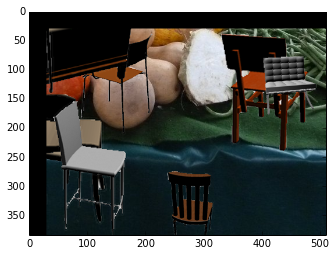

In [238]:
show_image(it0_translate)

In [240]:
h = it0.shape[0]
w = it0.shape[1]

it0_translate = translate_image(it0, 30, 30)
flow = generate_translation_flow(h, w, x=30, y=30)
it0_expected_before = flow = apply_flow(it0_translate, flow)

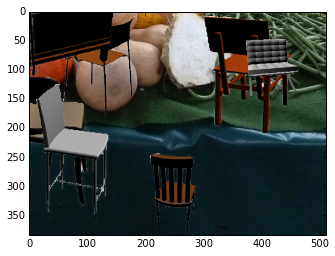

In [243]:
show_image(it0)

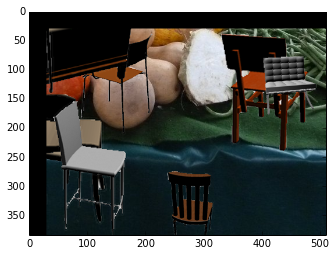

In [244]:
show_image(it0_translate)

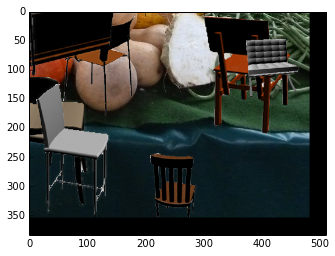

In [241]:
show_image(it0_expected_before)

In [246]:
def fine_tune():
    pass